# Reading the data and turning into a Dataframes

From the yelp dataset, the business and restaurants json files contain the data of intrest. 

In [1]:
import os # Miscellaneous operating system interfaces, used for finding path of files
import pandas as pd # for data manipulation and analysis.

## Read the business.json

In [2]:
path= os.path.abspath("business.json")
business = pd.read_json (path,lines=True)

Keep only businesses with 'Restaurants' in their category and 'Toronto' in city
Keep only 'business_id' and 'categories' columns

In [4]:
restaurants= business[business['categories'].str.contains('Restaurants',case=False,na=False)]
restaurants= restaurants[restaurants['city'].str.contains('Toronto',case=False,na=False)]
restaurants=restaurants[['business_id','categories']]
restaurants.head()

,business_id,categories
29,NDuUMJfrWk52RA-H-OtrpA,"Juice Bars & Smoothies, Food, Restaurants, Fas..."
32,SP_YXIEwkFPPl_9anCYmpQ,"Restaurants, Nightlife, Breakfast & Brunch, Ve..."
50,mlHC2XcU9Bows6cnYEmRgg,"Restaurants, Breakfast & Brunch, Bars, Modern ..."
83,RFbMVekR8lU9tPJ8sWrwHg,"Italian, Restaurants"
96,NPHZkn1e-tSJAbo8Zm9rYw,"Tex-Mex, Mexican, Restaurants"


Read the review json in chucks, otherwise memory error
and merge the reviews with the restaurants defined above


In [5]:
path= os.path.abspath("review.json")
size=100000
review = pd.read_json (path,lines=True,chunksize=size)
chunk_list = []
for chunk_review in review:
    chunk_review = chunk_review.drop(['review_id','useful','funny','cool'], axis=1)
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    chunk_merged = pd.merge(restaurants, chunk_review, on='business_id', how='inner')
    chunk_list.append(chunk_merged)
    
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
df.head()

,business_id,categories,user_id,review_stars,text,date
0,NDuUMJfrWk52RA-H-OtrpA,"Juice Bars & Smoothies, Food, Restaurants, Fas...",fd25NWbvLdNFJV_MoAljIg,4,Pretty solid vegan spot. Had a rice bowl there...,2017-10-11 00:28:10
1,NDuUMJfrWk52RA-H-OtrpA,"Juice Bars & Smoothies, Food, Restaurants, Fas...",AyxTBqPJjYqlY55vfNfB2Q,5,"What a great spot for a delicious, healthy lun...",2015-01-19 01:40:08
2,NDuUMJfrWk52RA-H-OtrpA,"Juice Bars & Smoothies, Food, Restaurants, Fas...",-KvhDluq5GhtiafY4xK2Sw,2,I really do love Bolt Fresh Bar. I've gone the...,2018-05-30 14:04:50
3,NDuUMJfrWk52RA-H-OtrpA,"Juice Bars & Smoothies, Food, Restaurants, Fas...",75DUiVsWkGZRW--zySVORA,4,"The vibe: Clean, bright vegetarian take out!\n...",2014-02-25 19:39:12
4,NDuUMJfrWk52RA-H-OtrpA,"Juice Bars & Smoothies, Food, Restaurants, Fas...",z23KjDT_pUtORz4ptHnUAg,2,I went here once to get the protein bowl and i...,2017-05-27 00:14:14


save the dataframes for easy access later

In [6]:
df.to_pickle('resturantreviews')
restaurants.to_pickle('restaurants')

# Exploritory Analysis

In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

In [3]:
reviews = pd.read_pickle('C:/Users/frede/.spyder-py3/py dir/Capstone/resturantreviews')      
restaurants = pd.read_pickle('C:/Users/frede/.spyder-py3/py dir/Capstone/restaurants')

### Exploring the Category of a review

In [9]:
categoryfreq={}
for item in restaurants['categories']:
    for word in item.split(", "):
        if word not in categoryfreq:
            categoryfreq[word]=0
        categoryfreq[word]+=1

sorted (categoryfreq.items(), key=lambda item: item[1])

Cfreqdf = pd.DataFrame.from_dict(categoryfreq,orient='index').reset_index()
Cfreqdf= Cfreqdf.rename(columns={'index':'category',0:'count'})
Cfreqdf=Cfreqdf.sort_values(by=['count'],ascending=False).drop([2]).reset_index()
del Cfreqdf['index']

print('There are', len(Cfreqdf),'categories with',len(Cfreqdf[Cfreqdf['count']==1]),'used only once.')
print('only the top few categories are useful for grouping the restaurants due to the few examples in less popular categories.\n')
Cfreqdf[Cfreqdf['count']==1]

top10=Cfreqdf.head(10)

top10.loc[5,'category']='Canadian' # don't know why 'Canadian (New)' doesn't work

starmean=[]

for i in top10['category']:
    
    k=np.mean(reviews.loc[reviews.categories.str.contains(i,case=False,na=False),"review_stars"])
    starmean.append(k)
    

top10.insert(2,"average_stars",starmean,True)
print("Top 10 most frequent Categories out of 7967 Restaurants")
top10

There are 366 categories with 95 used only once.
only the top few categories are useful for grouping the restaurants due to the few examples in less popular categories.



C:\Users\frede\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Top 10 most frequent Categories out of 7967 Restaurants


,category,count,average_stars
0,Food,2057,3.650492
1,Nightlife,1111,3.566375
2,Bars,1063,3.581973
3,Sandwiches,705,3.730448
4,Breakfast & Brunch,700,3.633698
5,Canadian,695,3.588449
6,Cafes,680,3.770053
7,Chinese,652,3.420741
8,Coffee & Tea,632,3.767088
9,Italian,631,3.622945


### Exploring Reviews overtime

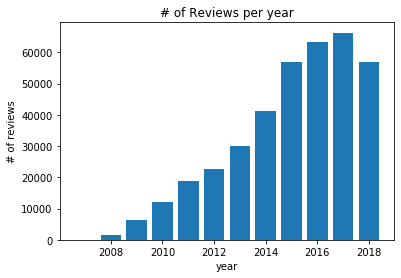

The latest review is 2018-11-14 18:04:51 which could account for the lower than expected number of reviews in 2018


In [10]:
# counting reviews and year
reviewyear=pd.value_counts(reviews['date'].dt.year).to_frame().reset_index()
reviewyear.columns=['year','count']
reviewyear=reviewyear.sort_values(by=['year'])
# plotting in a bar graph
plt.bar(reviewyear['year'],reviewyear['count'])
plt.title('# of Reviews per year')
plt.xlabel('year')
plt.ylabel('# of reviews')
plt.show()
print('The latest review is 2018-11-14 18:04:51 which could account for the lower than expected number of reviews in 2018')


### Average star ratings over time 

First 5 months omitted since they had less than 3 reviews for that month
average rating seems to increase over time at around 2012
trendline is from using line of best fit starting at 2011-07
trendline equation is y =0.00287 x +3.35
where y is the average star rating and x is the number of months since 2011-07


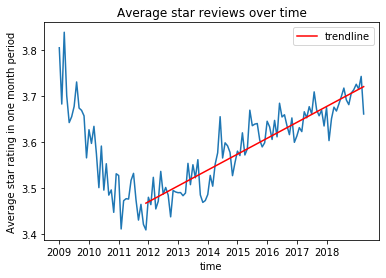

r^2 of 0.8389942112884174 for the trendline which


In [11]:
reviews['monthyear']=reviews['date'].dt.to_period('M')
a= reviews.sort_values(['monthyear']).groupby('monthyear')['review_stars'].mean().reset_index()
print('First 5 months omitted since they had less than 3 reviews for that month')
plt.plot(a['review_stars'][5:],zorder=1)
plt.xticks(list(range(5,122,12)),list(range(2009,2019)))
plt.title("Average star reviews over time")
plt.xlabel('time')
plt.ylabel('Average star rating in one month period')


reviews.sort_values(['monthyear']).groupby('monthyear')['review_stars'].count().head(10)

print("average rating seems to increase over time at around 2012")
print("trendline is from using line of best fit starting at 2011-07")
print("trendline equation is y =0.00287 x +3.35")
print("where y is the average star rating and x is the number of months since 2011-07")

x=np.array(range(40,129))
p=np.poly1d(np.polyfit(x,np.array(a['review_stars'][40:]),1))
plt.plot(x,p(x),"r",zorder=2,label='trendline')
plt.legend()

plt.show()
r=np.corrcoef(np.array(a['review_stars'][40:]),p(x))[0,1]**2
print("r^2 of",r, 'for the trendline which')

### Distirbution of # of Reviews per Restuarant

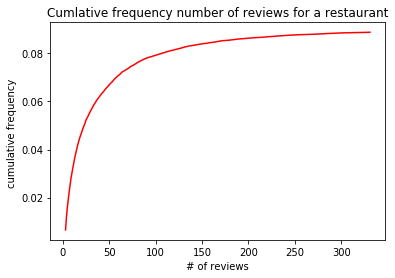

~50% of the restaurants have less than 20 review
~80% of the restaurants have less than 100 review


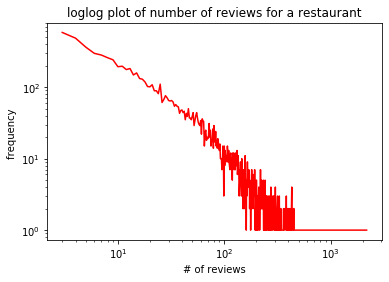

~50% of the restaurants have less than 20 review


In [12]:
r=pd.value_counts(reviews['business_id']).to_frame().reset_index()
rfreq=pd.value_counts((r['business_id'])).to_frame().reset_index().sort_values(by=['index'])
rfreq.columns=['reviews','count']



rfreq=rfreq.sort_values(by=['reviews'])
b2=plt.plot(rfreq['reviews'][0:300],np.cumsum(rfreq['count'][0:300]/88437),color='r',label='cumulative frequency')
plt.title('Cumlative frequency number of reviews for a restaurant')
plt.xlabel('# of reviews')
plt.ylabel('cumulative frequency ')
plt.show()
print("~50% of the restaurants have less than 20 review")
print("~80% of the restaurants have less than 100 review")
b3=plt.plot(rfreq['reviews'],(rfreq['count']),color='r',label='cumulative frequency')
plt.title('loglog plot of number of reviews for a restaurant')
plt.xlabel('# of reviews')
plt.ylabel('frequency ')
plt.yscale("log")
plt.xscale("log")
plt.show()
print("~50% of the restaurants have less than 20 review")

### Distirbution of # of Reviews per User

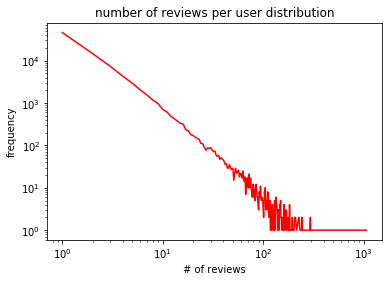

In [13]:
users=pd.value_counts(reviews['user_id']).to_frame().reset_index()
userreviews=pd.value_counts(users['user_id']).to_frame().reset_index().sort_values(by=['index'])
userreviews.columns=['reviews','count']


#plotting

plt.title('number of reviews per user distribution on loglog plot')
plt.xlabel('# of reviews')
plt.ylabel('frequency')
b4=plt.plot(userreviews['reviews'],(userreviews['count']),color='r',label='cumulative frequency')




plt.yscale("log")
plt.xscale("log")



plt.show()

### Distribution of stars

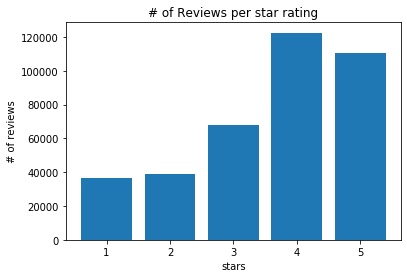

In [14]:

reviewstars=pd.value_counts(reviews['review_stars']).to_frame().reset_index().sort_values(by=['index'])
reviewstars.columns=['stars','count']
#plotting
plt.bar(reviewstars['stars'],reviewstars['count'])
plt.title('# of Reviews per star rating')
plt.xlabel('stars')
plt.ylabel('# of reviews')
plt.show()


### Distribution of Number of Characters in Reviews

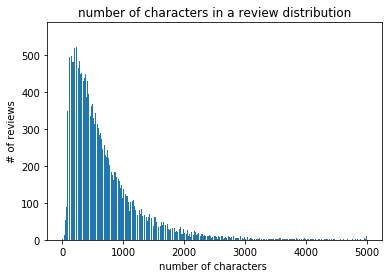

the mean number of characters per review is 2292.485234899329


In [16]:
reviewchar=pd.value_counts(reviews['text'].apply(len)).to_frame().reset_index().sort_values(by=['index'])
reviewchar.columns=['char','count']
plt.bar(reviewchar['char'],reviewchar['count'])
plt.title('number of characters in a review distribution')
plt.xlabel('number of characters ')
plt.ylabel('# of reviews')
plt.show()
print('the mean number of characters per review is', np.mean(reviewchar['char']))

# Preprocessing

remove 3 stars, since it can contain both positve and negetive sentiment
goal is to define positive and negetive sentimnet

In [48]:
# import libraries
import pandas as pd 

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer


from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import string
import re


In [2]:
# load reviews dataframe if necessary
reviews = pd.read_pickle('C:/Users/frede/.spyder-py3/py dir/Capstone/resturantreviews') 

In [3]:
reviews=reviews[reviews['review_stars']!=3] #remove 3 stars
reviews['review_stars']= reviews['review_stars']>3


In [6]:
Lancaster=LancasterStemmer()
stop_words=[word.translate(str.maketrans(' ', ' ', string.punctuation)) for word in stopwords.words('english')]
def preprocess(text):
    #returns tokenize text to words and stemming words
    text=text.translate(str.maketrans(' ', ' ', string.punctuation))#remove all puncuation
    text=text.lower()#lower case
    return [Lancaster.stem(word) for word in text.split() if not word.lower() in stop_words]

In [11]:
#apply preprocess to text
X=reviews['text'].apply(preprocess)

In [12]:
#split into train and test set
y=reviews.review_stars
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [13]:
# treat class imbalance

In [24]:
Train = pd.concat([xTrain, yTrain], axis=1)
Positive=Train[Train.review_stars==True]
Negetive=Train[Train.review_stars==False]
Trainresampled=resample(Negetive,replace=True,n_samples=len(Positive),random_state=0)
Train= pd.concat([Positive, Trainresampled])
Test = pd.concat([xTest, yTest], axis=1)


In [15]:
#dummy function that does nothing, to be passed as preprocessor argument and tokenizer argument in countvectorizer
# since text is already preprocessed and tokenized
def dummy(input):
    return input

In [28]:
Train2=count2.transform(Train['text'])
Testcount2=count2.transform(Test['text'])

In [29]:
# take a look at bigrams as well as unigrams
count3=CountVectorizer(ngram_range=(1, 2), 
                      min_df=0.01,max_df=0.5,
                     preprocessor= dummy,tokenizer=dummy
                     )
count3.fit(Train['text'])
print(len(count3.vocabulary_) , 'words with unigrams and bigrams')

1034

In [30]:
Train3=count3.transform(Train['text'])
Testcount3=count3.transform(Test['text'])

In [32]:
# using only bigrams
count4=CountVectorizer(ngram_range=(2, 2),
                      min_df=0.01,max_df=0.5,
                     preprocessor= dummy,tokenizer=dummy
                     )
count4.fit(Train['text'])

106

In [33]:
Train4=count4.transform(Train['text'])
Testcount4=count4.transform(Test['text'])

In [36]:

Tfidfvector=TfidfVectorizer(tokenizer=dummy,preprocessor=dummy,min_df=0.01,max_df=0.5)
Tfidfvector.fit(Train['text'])
TrainTfidf=Tfidfvector.transform(Train['text'])
TestTfidf=Tfidfvector.transform(Test['text'])
len(Tfidfvector.vocabulary_)

928

In [55]:
Tfidfvector2=TfidfVectorizer(ngram_range=(1, 2),tokenizer=dummy,preprocessor=dummy,min_df=0.01,max_df=0.5)
Tfidfvector2.fit(Train['text'])
TrainTfidf2=Tfidfvector2.transform(Train['text'])
TestTfidf2=Tfidfvector2.transform(Test['text'])
len(Tfidfvector2.vocabulary_)

C:\Users\frede\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


1034

In [56]:
Tfidfvector3=TfidfVectorizer(ngram_range=(2, 2),tokenizer=dummy,preprocessor=dummy,min_df=0.01,max_df=0.5)
Tfidfvector3.fit(Train['text'])
TrainTfidf3=Tfidfvector3.transform(Train['text'])
TestTfidf3=Tfidfvector3.transform(Test['text'])


C:\Users\frede\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


106

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

def metriclist(model,test):
    # returns accuracy, f1 score, precision ,recall in a list
    return[accuracy_score(Test['review_stars'], model.predict(test)),
           f1_score(Test['review_stars'], model.predict(test)),
           precision_score(Test['review_stars'], model.predict(test)),
           recall_score(Test['review_stars'], model.predict(test))]
def LRinitNfit(Transtrain):
    #creates LR model and fits it to training data
    lr = LogisticRegression(solver='lbfgs', max_iter=7600)
    lr.fit(Transtrain, Train['review_stars'])
    return lr
def SVMinitNfit(Transtrain):
    #creates svm model and fits it to training data
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(Transtrain, Train['review_stars'])
    return SVM
def gethlcoef(vectorizer,model):
    #prints 5 highest and 5 lowest coefficients in LR model
    feature_to_coef = {
    word: coef for word, coef in zip(
        vectorizer.get_feature_names(), model.coef_[0]
        )
    }
    print ("words associated with highest coeffient")
    for best_positive in sorted(
        feature_to_coef.items(), 
        key=lambda x: x[1], 
        reverse=True)[:5]:
        print (best_positive)

    print ("words associated with lowest coeffient")
    for best_negative in sorted(
        feature_to_coef.items(), 
        key=lambda x: x[1])[:5]:
        print (best_negative)

### Logistic regression classification 

In [39]:
lr2 = LRinitNfit(Train2)

In [40]:
lr3 = LRinitNfit(Train3)

In [41]:
lr4 = LRinitNfit(Train4)

In [57]:
lrtf = LRinitNfit(TrainTfidf)
lrtf2 = LRinitNfit(TrainTfidf2)
lrtf3 = LRinitNfit(TrainTfidf3)

In [46]:
print('Logistic regression using count representation')
d={'unigram':metriclist(lr2,Testcount2),
   'uni+bigrams':metriclist(lr3,Testcount3),
   'bigram':metriclist(lr4,Testcount4)}
pd.DataFrame(d,index=['Accuracy','f1_score','Precision','Recall'])

Logistic regression using count representation


,unigram,uni+bigrams,bigram
Accuracy,0.920742,0.923396,0.614986
f1_score,0.946350,0.948148,0.684466
Precision,0.969673,0.971486,0.900416
Recall,0.924122,0.925905,0.552062


In [58]:
print('Logistic regression using Tfidf representation')
d={'unigram':metriclist(lrtf,TestTfidf),
   'uni+bigrams':metriclist(lrtf2,TestTfidf2),
   'bigram':metriclist(lrtf3,TestTfidf3)}
pd.DataFrame(d,index=['Accuracy','f1_score','Precision','Recall'])

Logistic regression using Tfidf representation


,unigram,uni+bigrams,bigram
Accuracy,0.919706,0.922986,0.616044
f1_score,0.945497,0.947772,0.686082
Precision,0.971638,0.973029,0.899050
Recall,0.920726,0.923793,0.554687


In [64]:
print('LR unigram')
gethlcoef(count2,lr2)

LR unigram
words associated with highest coeffient
('gem', 1.926456071771681)
('fantast', 1.634872220395646)
('delicy', 1.6309726194008043)
('amaz', 1.5359678042886156)
('excel', 1.5265946457012456)
words associated with lowest coeffient
('worst', -2.6899706810979627)
('tasteless', -2.6826611982037503)
('horr', -2.4756530259554275)
('disgust', -2.435246948157792)
('mediocr', -2.43408100102769)


In [62]:
print('LR uni+bigram')
gethlcoef(count3,lr3)

LR uni+bigram
words associated with highest coeffient
('high recommend', 2.0978025047163973)
('gem', 1.9399698767918663)
('5 star', 1.656539868306261)
('fantast', 1.6272632985433182)
('delicy', 1.6197421834972963)
words associated with lowest coeffient
('worst', -2.7179901507983693)
('tasteless', -2.64570802959374)
('horr', -2.4352616938574463)
('mediocr', -2.400254780010861)
('disgust', -2.34417380984306)


In [63]:
print('LR bigram')
gethlcoef(count4,lr4)

LR bigram
words associated with highest coeffient
('high recommend', 2.507855686787525)
('on best', 2.1789201466124926)
('definit com', 2.168440987517963)
('back try', 1.9862953703713329)
('food delicy', 1.814240281456597)
words associated with lowest coeffient
('noth spec', -1.6369432012896614)
('serv slow', -1.5485131857570589)
('tast lik', -1.279916602251189)
('told us', -1.2293020157391874)
('real want', -1.2020037683708373)


In [68]:
gethlcoef(Tfidfvector,lrtf)
gethlcoef(Tfidfvector2,lrtf2)
gethlcoef(Tfidfvector3,lrtf3)

words associated with highest coeffient
('delicy', 13.327684130946205)
('perfect', 10.646158886501041)
('amaz', 10.62886865205201)
('fantast', 8.703162088886065)
('excel', 8.463302140224977)
words associated with lowest coeffient
('worst', -13.445926574945528)
('bland', -12.003908608197518)
('mediocr', -11.561518505028785)
('horr', -10.695955599963614)
('terr', -10.224568061133022)
words associated with highest coeffient
('delicy', 13.575083452540476)
('perfect', 10.783958282315082)
('amaz', 10.752312554785636)
('high recommend', 9.296447206898355)
('fantast', 8.839510656196907)
words associated with lowest coeffient
('worst', -13.740304957857127)
('bland', -12.318663490931705)
('mediocr', -11.623047526614288)
('horr', -10.704837840514372)
('terr', -10.390666944762781)
words associated with highest coeffient
('high recommend', 3.8858522708788237)
('definit com', 3.4521800315298647)
('on best', 3.3045968083932933)
('back try', 3.094028350334236)
('would definit', 2.944888005203638)
word

In [ ]:
### linear SVM

Tpic modeling using gensim

In [112]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *


In [124]:
positive=reviews[reviews['review_stars']==True]['snow']
negetive=reviews[reviews['review_stars']==False]['snow']

In [125]:
dictionary1=gensim.corpora.Dictionary(positive)
dictionary0=gensim.corpora.Dictionary(negetive)

In [126]:
# tokens that appear in more than 15 and less than 50% of doucuments 
#keeping only 100000 most frequent
dictionary1.filter_extremes(no_below=15, no_above=0.5, keep_n=100000) 
dictionary0.filter_extremes(no_below=15, no_above=0.5, keep_n=100000) 

In [127]:
# occurances of each word for wach review
bow_corpus1 = [dictionary1.doc2bow(doc) for doc in positive]
bow_corpus0 = [dictionary0.doc2bow(doc) for doc in negetive]

In [116]:
from gensim import corpora, models

In [130]:
#tfidif model
tfidf1 = models.TfidfModel(bow_corpus1)
corpus_tfidf1 = tfidf[bow_corpus1]
tfidf0 = models.TfidfModel(bow_corpus0)
corpus_tfidf0 = tfidf[bow_corpus0]

In [131]:
lda_model1 = gensim.models.LdaMulticore(bow_corpus1, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [132]:
for idx, topic in lda_model1.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.013*"buttermilk" + 0.012*"everyth" + 0.012*"still" + 0.011*"friend" + 0.010*"soup" + 0.010*"happi" + 0.008*"choic" + 0.008*"place" + 0.007*"veggi" + 0.007*"menu"
Topic: 1 
Words: 0.021*"select" + 0.017*"place" + 0.013*"pita" + 0.012*"friend" + 0.011*"ive" + 0.011*"textur" + 0.010*"bleu" + 0.009*"singl" + 0.009*"repeat" + 0.008*"set"
Topic: 2 
Words: 0.022*"entir" + 0.014*"cant" + 0.014*"happi" + 0.013*"share" + 0.012*"ive" + 0.011*"pace" + 0.011*"meet" + 0.009*"sea" + 0.009*"counter" + 0.009*"decent"
Topic: 3 
Words: 0.024*"type" + 0.018*"buttermilk" + 0.016*"doughi" + 0.016*"paneer" + 0.014*"counter" + 0.013*"friend" + 0.013*"ive" + 0.012*"happi" + 0.012*"valentin" + 0.011*"experi"
Topic: 4 
Words: 0.031*"night" + 0.019*"didnt" + 0.016*"date" + 0.014*"want" + 0.011*"school" + 0.011*"ive" + 0.010*"right" + 0.009*"turn" + 0.009*"dissappoint" + 0.009*"happi"
Topic: 5 
Words: 0.040*"friend" + 0.037*"place" + 0.033*"ive" + 0.025*"cevich" + 0.023*"select" + 0.023*"soup" +

In [133]:
lda_model_tfidf1 = gensim.models.LdaMulticore(corpus_tfidf1, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf1.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.029*"bigoli" + 0.020*"calzon" + 0.012*"meet" + 0.011*"solid" + 0.010*"rage" + 0.008*"select" + 0.008*"center" + 0.007*"mai" + 0.007*"share" + 0.006*"hangout"
Topic: 1 Word: 0.012*"entir" + 0.011*"select" + 0.008*"hangout" + 0.008*"thrown" + 0.008*"sea" + 0.008*"repeat" + 0.007*"happi" + 0.007*"czech" + 0.007*"juici" + 0.007*"smoki"
Topic: 2 Word: 0.016*"pita" + 0.013*"soup" + 0.013*"select" + 0.012*"nunu" + 0.011*"repeat" + 0.011*"appreci" + 0.011*"friend" + 0.010*"mud" + 0.010*"most" + 0.010*"thrown"
Topic: 3 Word: 0.013*"cevich" + 0.009*"hangout" + 0.009*"sea" + 0.008*"select" + 0.007*"repeat" + 0.006*"share" + 0.006*"juici" + 0.006*"thrown" + 0.005*"date" + 0.005*"expens"
Topic: 4 Word: 0.010*"buttermilk" + 0.007*"moon" + 0.007*"bream" + 0.007*"most" + 0.007*"sea" + 0.006*"hangout" + 0.006*"happi" + 0.006*"ink" + 0.005*"pita" + 0.005*"ate"
Topic: 5 Word: 0.012*"select" + 0.012*"bleu" + 0.011*"pita" + 0.008*"smile" + 0.008*"repeat" + 0.008*"hangout" + 0.007*"textur" 

In [134]:
lda_model0 = gensim.models.LdaMulticore(bow_corpus0, num_topics=10, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model0.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.022*"vege" + 0.021*"return" + 0.017*"classico" + 0.011*"wasnt" + 0.010*"salti" + 0.010*"perfect" + 0.009*"complement" + 0.009*"omelett" + 0.009*"school" + 0.009*"jam"
Topic: 1 
Words: 0.013*"your" + 0.012*"vege" + 0.012*"follow" + 0.011*"seat" + 0.010*"peopl" + 0.010*"hope" + 0.010*"persian" + 0.010*"overs" + 0.010*"scarborough" + 0.009*"market"
Topic: 2 
Words: 0.022*"squash" + 0.017*"follow" + 0.013*"want" + 0.010*"healthi" + 0.009*"pork" + 0.008*"glass" + 0.008*"salad" + 0.008*"bowl" + 0.007*"vegetarian" + 0.007*"deni"
Topic: 3 
Words: 0.015*"market" + 0.010*"follow" + 0.009*"vege" + 0.009*"hous" + 0.009*"your" + 0.009*"omelett" + 0.008*"most" + 0.008*"seat" + 0.007*"want" + 0.007*"super"
Topic: 4 
Words: 0.014*"want" + 0.011*"dealt" + 0.011*"complement" + 0.008*"market" + 0.007*"follow" + 0.007*"omelett" + 0.007*"vegetarian" + 0.007*"salad" + 0.006*"attent" + 0.006*"bream"
Topic: 5 
Words: 0.027*"away" + 0.022*"wasnt" + 0.017*"perfect" + 0.016*"complement" + 0.01

In [135]:
lda_model_tfidf0 = gensim.models.LdaMulticore(corpus_tfidf0, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf0.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.009*"rees" + 0.008*"departur" + 0.008*"vege" + 0.008*"bream" + 0.007*"glass" + 0.007*"market" + 0.006*"wasnt" + 0.006*"want" + 0.006*"follow" + 0.006*"penn"
Topic: 1 Word: 0.014*"parantha" + 0.011*"market" + 0.011*"departur" + 0.010*"omelett" + 0.009*"bream" + 0.008*"want" + 0.008*"glass" + 0.008*"follow" + 0.007*"middl" + 0.007*"vege"
Topic: 2 Word: 0.009*"vege" + 0.006*"market" + 0.006*"departur" + 0.006*"follow" + 0.006*"bream" + 0.004*"omelett" + 0.004*"czech" + 0.004*"expand" + 0.003*"school" + 0.003*"hypocrit"
Topic: 3 Word: 0.028*"vege" + 0.011*"mccaul" + 0.008*"departur" + 0.008*"bream" + 0.007*"market" + 0.007*"complexion" + 0.006*"broccoli" + 0.006*"follow" + 0.006*"classico" + 0.006*"hope"
Topic: 4 Word: 0.018*"vege" + 0.010*"follow" + 0.010*"market" + 0.009*"squash" + 0.009*"healthi" + 0.008*"persian" + 0.007*"hope" + 0.007*"overs" + 0.007*"departur" + 0.007*"bream"
Topic: 5 Word: 0.041*"prejudic" + 0.019*"vege" + 0.008*"follow" + 0.008*"market" + 0.007*"pe

SyntaxError: invalid syntax (<ipython-input-141-47e7308e9c7c>, line 1)